# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [32]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

In [106]:
#use this cell to import additional libraries or define helper functions
from keras.layers import Conv1D, MaxPooling1D
from keras import regularizers

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [33]:
#Load your data into a pandas dataframe here
df = pd.read_csv('../aai530-assignment3/data-assignment2.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [47]:
#create your training and validation sets here
np.random.seed(1234)  

#assign size for data subset
subset_size = int(len(df) * 0.01)

#take random data subset
index = np.random.randint(0, len(df) - subset_size)
random_data = df.iloc[index:index + subset_size]

#split data subset 80/20 for train/validation
split = int(len(random_data) * 0.8)
train_df = random_data[:split]
val_df = random_data[split:]

In [48]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [50]:
seq_arrays = []
seq_labs = []

In [51]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
for i in range(len(train_df) - seq_length - ph):
    # extract sequence
    seq = train_df[feat_cols].iloc[i:i+seq_length].values
    # extract label at ph
    label = train_df[feat_cols].iloc[i+seq_length+ph-1].values[0]

    # store sequence and label
    seq_arrays.append(seq)
    seq_labs.append(label)

#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [59]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [61]:
seq_arrays.shape

(16358, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: Asserts are used for code validation and specifically in this situation it is used to ensure that our seq_arrays and seq_labs variables have the correct shape. It is better to add validations like this in while moving through your data prep process so that when you get to modeling weird errors arent being thrown. If you handle it here you know when you get to modeling that the data shouldn't be the issues. 

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [65]:
# define path to save model
model_path = 'LSTM_model1.keras'

# build the network
nb_features = seq_arrays.shape[2] #num of features
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5, #hidden units
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

2025-02-04 01:26:57.111480: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 5)          │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3)              │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 15s - 475ms/step - loss: 2.4648 - mse: 2.4648 - val_loss: 0.3594 - val_mse: 0.3594
Epoch 2/100
32/32 - 3s - 88ms/step - loss: 0.9331 - mse: 0.9331 - val_loss: 0.2753 - val_mse: 0.2753
Epoch 3/100
32/32 - 2s - 73ms/step - loss: 0.7524 - mse: 0.7524 - val_loss: 0.2485 - val_mse: 0.2485
Epoch 4/100
32/32 - 3s - 89ms/step - loss: 0.6866 - mse: 0.6866 - val_loss: 0.2411 - val_mse: 0.2411
Epoch 5/100
32/32 - 3s - 82ms/step - loss: 0.6257 - mse: 0.6257 - val_loss: 0.2373 - val_mse: 0.2373
Epoch 6/100
32/32 - 2s - 74ms/step - loss: 0.6136 - mse: 0.6136 - val_loss: 0.2314 - val_mse: 0.2314
Epoch 7/100
32/32 - 3s - 81ms/step - loss: 0.6022 - mse: 0.6022 - val_loss: 0.2285 - val_mse: 0.2285
Epoch 8/100
32/32 - 2s - 76ms/step - loss: 0.5891 - mse: 0.5891 - val_loss: 0.2253 - val_mse: 0.2253
Epoch 9/100
32/32 - 3s - 91ms/step - loss: 0.5640 - mse: 0.5640 - val_loss: 0.2210 - val_mse: 0.2210
Epoch 10/100
32/32 - 2s - 77ms/step - loss: 0.5451 - mse: 0.5451 - val_loss: 0.2205 

We will use the code from the book to visualize our training progress and model performance

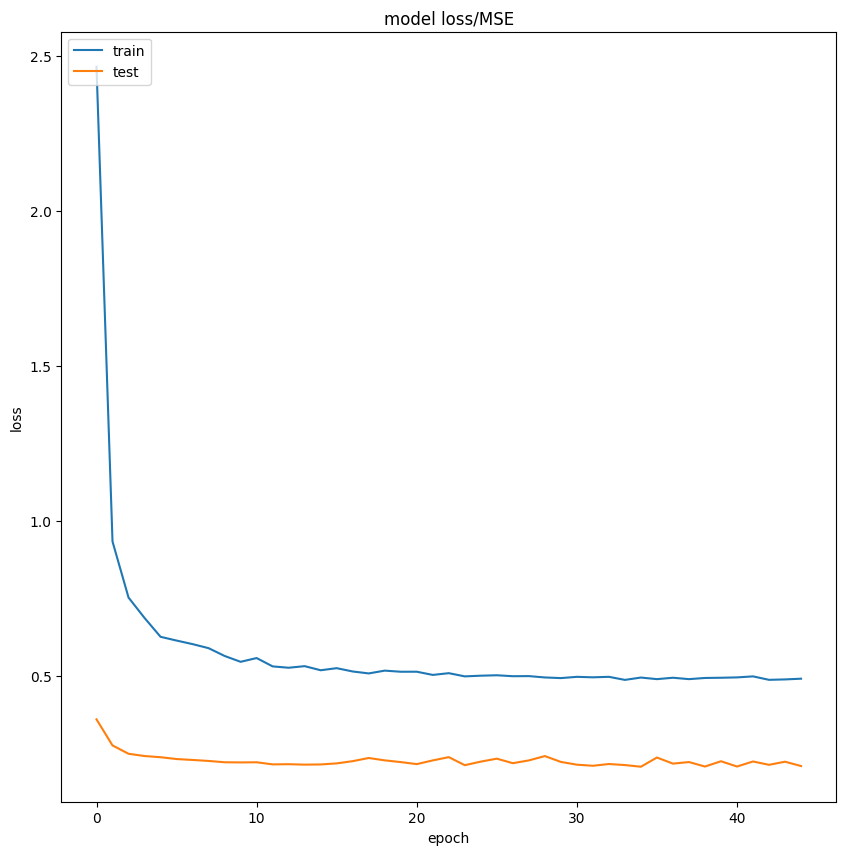

In [66]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: The pad_sequences functions helps to regulate sequence length, for inputs that are smaller than a set length it automatically pads the sequence with zeros or some other value if you specify. The padding argument is there to determine where the padding happens (ie post or pre), so either before or after the input sequence. For this case it makes the most sens to pad the value with 'pre' because ensures that we are able to start the model at the earliest available data point. 

In [77]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
for i in range(seq_length, len(val_df) - ph):
    seq = val_df[feat_cols].iloc[i-seq_length:i].values # these are already GAP 
    label = val_df[feat_cols].iloc[i+ph].values[0]

    # save values
    val_arrays.append(seq)
    val_labs.append(label)

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, padding='pre', dtype='float32')
        
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

127/127 - 1s - 7ms/step - loss: 0.3804 - mse: 0.3804

MSE: 0.3803566098213196
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


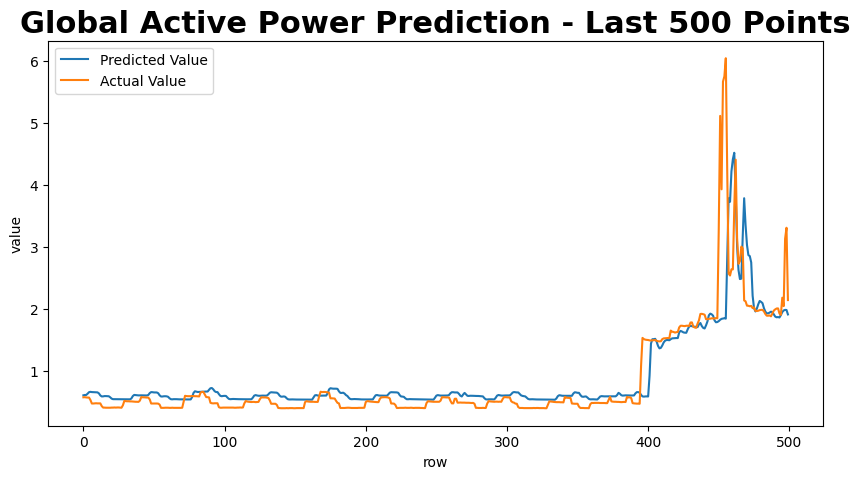

In [79]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: By looking at the MSE and taking into account the value range we can conclude that the model did okay. By taking a look at the GAP predictions we can see that the predicted values tend to be over estimated for the first 400 rows and undersetimated when the value is around 2 and up. By looking at the loss curves we can see that the train and test sets never converge which can signify some issues with the model. Some of these issues include overfitting and underfitting, which we can check and address by changing the number of LSTM layers, changing the dropout rates, or adjusting sequence lengths. 


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: For my first experimentation model I am going to adjust just the number of hidden layers in each of the LSTM layers. I am going to double the hidden layers because I think this can help the model capture more complex patterns and then change the optimizer to be RMSprop which is suited for sequential data like our data. I expect the hidden layer increase to help model performance but the optimizer is more of an experiment. For the second model I want to implement a convolutional layer to help extract some local patterns, mainly because the data is drastically different at the end of the predictions. 

In [94]:
# play with your ideas for optimization here
# define path to save model
model_path = 'LSTM_model2.keras'

# build the network
nb_features = seq_arrays.shape[2] #num of features
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=20, #hidden units
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=12,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.RMSprop(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())


/usr/local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 30, 20)         │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 12)             │         1,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            13 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,357 (13.11 KB)

 Trainable params: 3,357 (13.11 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 8s - 243ms/step - loss: 0.9025 - mse: 0.9025 - val_loss: 0.2716 - val_mse: 0.2716
Epoch 2/100
32/32 - 3s - 86ms/step - loss: 0.5910 - mse: 0.5910 - val_loss: 0.2521 - val_mse: 0.2521
Epoch 3/100
32/32 - 3s - 96ms/step - loss: 0.5134 - mse: 0.5134 - val_loss: 0.2619 - val_mse: 0.2619
Epoch 4/100
32/32 - 3s - 95ms/step - loss: 0.5105 - mse: 0.5105 - val_loss: 0.2169 - val_mse: 0.2169
Epoch 5/100
32/32 - 3s - 95ms/step - loss: 0.4809 - mse: 0.4809 - val_loss: 0.2510 - val_mse: 0.2510
Epoch 6/100
32/32 - 3s - 100ms/step - loss: 0.4814 - mse: 0.4814 - val_loss: 0.4857 - val_mse: 0.4857
Epoch 7/100
32/32 - 4s - 123ms/step - loss: 0.4702 - mse: 0.4702 - val_loss: 0.2026 - val_mse: 0.2026
Epoch 8/100
32/32 - 3s - 84ms/step - loss: 0.4590 - mse: 0.4590 - val_loss: 0.2513 - val_mse: 0.2513
Epoch 9/100
32/32 - 2s - 72ms/step - loss: 0.4524 - mse: 0.4524 - val_loss: 0.2261 - val_mse: 0.2261
Epoch 10/100
32/32 - 2s - 66ms/step - loss: 0.4441 - mse: 0.4441 - val_loss: 0.3028

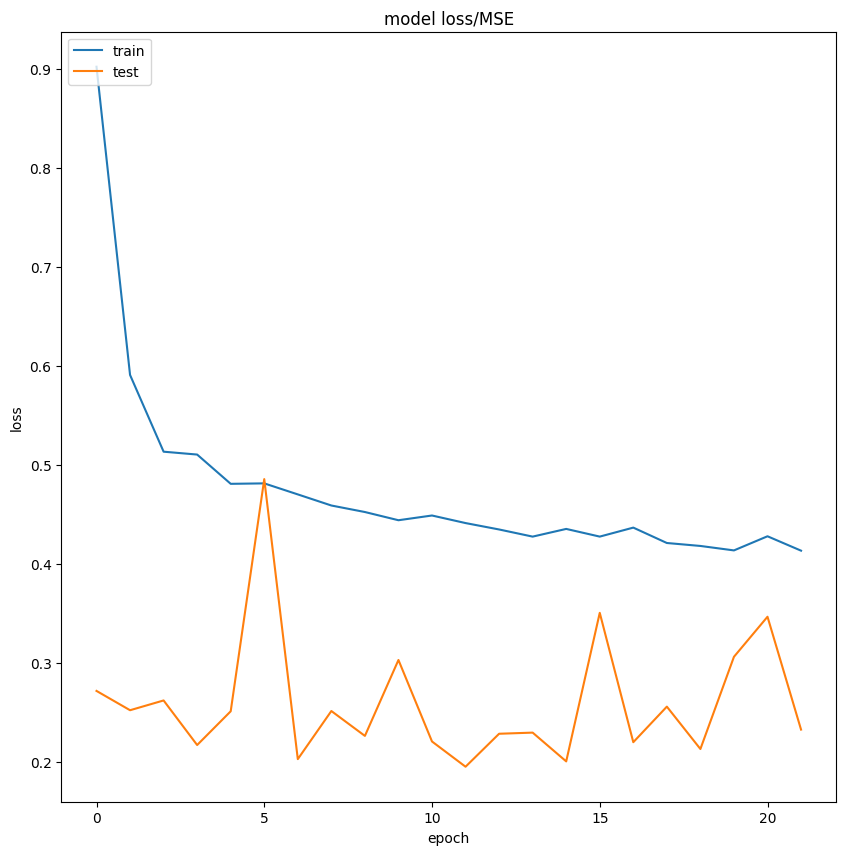

In [95]:

# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

127/127 - 1s - 11ms/step - loss: 0.3817 - mse: 0.3817

MSE: 0.3816549479961395
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


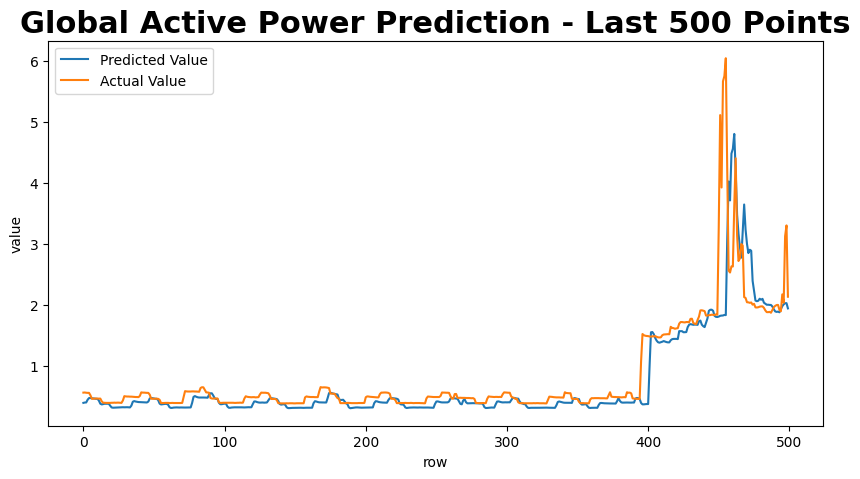

In [97]:
# show me how one or two of your different models perform 
# using the code from the "Validating our model" section above

# experimentation model 1 results
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
for i in range(seq_length, len(val_df) - ph):
    seq = val_df[feat_cols].iloc[i-seq_length:i].values # these are already GAP 
    label = val_df[feat_cols].iloc[i+ph].values[0]

    # save values
    val_arrays.append(seq)
    val_labs.append(label)

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, padding='pre', dtype='float32')
        
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

In [128]:
# experimentation model 2
model_path = 'LSTM_model3.keras'

# build the network
nb_features = seq_arrays.shape[2] #num of features
nb_out = 1

model = Sequential()

# add convolutional layer
model.add(Conv1D(
    filters=128,
    kernel_size=3,
    strides=1,
    input_shape=(seq_length, nb_features),
    activation='linear',
    padding='same'
))
# adding maxpooling layer
model.add(MaxPooling1D(pool_size=3))

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=50, #hidden units
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=25,
          return_sequences=False))

# add a fully connected dense layer 
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))

model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.005)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 30, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 10, 50)         │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,938 (171.63 KB)

 Trainable params: 43,938 (171.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 12s - 375ms/step - loss: 0.8829 - mse: 0.8829 - val_loss: 0.2997 - val_mse: 0.2997
Epoch 2/100
32/32 - 3s - 102ms/step - loss: 0.4876 - mse: 0.4876 - val_loss: 0.2883 - val_mse: 0.2883
Epoch 3/100
32/32 - 3s - 102ms/step - loss: 0.4463 - mse: 0.4463 - val_loss: 0.2821 - val_mse: 0.2821
Epoch 4/100
32/32 - 3s - 109ms/step - loss: 0.4423 - mse: 0.4423 - val_loss: 0.2221 - val_mse: 0.2221
Epoch 5/100
32/32 - 3s - 107ms/step - loss: 0.4414 - mse: 0.4414 - val_loss: 0.2217 - val_mse: 0.2217
Epoch 6/100
32/32 - 3s - 91ms/step - loss: 0.4363 - mse: 0.4363 - val_loss: 0.2279 - val_mse: 0.2279
Epoch 7/100
32/32 - 3s - 95ms/step - loss: 0.4214 - mse: 0.4214 - val_loss: 0.2196 - val_mse: 0.2196
Epoch 8/100
32/32 - 3s - 108ms/step - loss: 0.4137 - mse: 0.4137 - val_loss: 0.2270 - val_mse: 0.2270
Epoch 9/100
32/32 - 3s - 106ms/step - loss: 0.4220 - mse: 0.4220 - val_loss: 0.2441 - val_mse: 0.2441
Epoch 10/100
32/32 - 3s - 109ms/step - loss: 0.4101 - mse: 0.4101 - val_loss: 

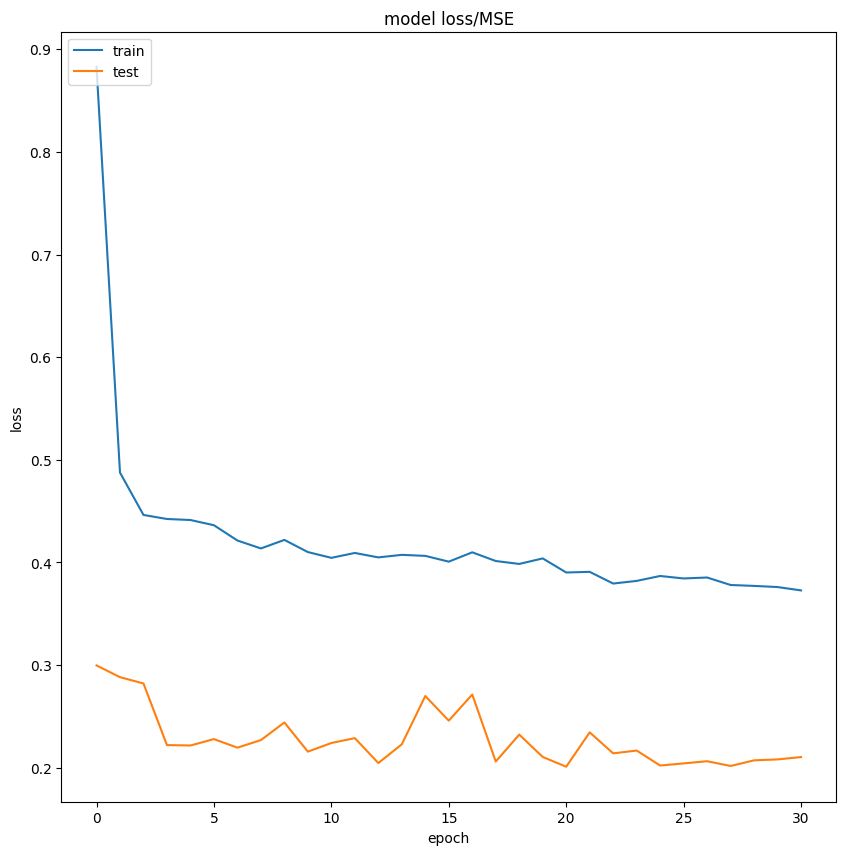

In [129]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

127/127 - 1s - 7ms/step - loss: 0.3758 - mse: 0.3758

MSE: 0.3758027255535126
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


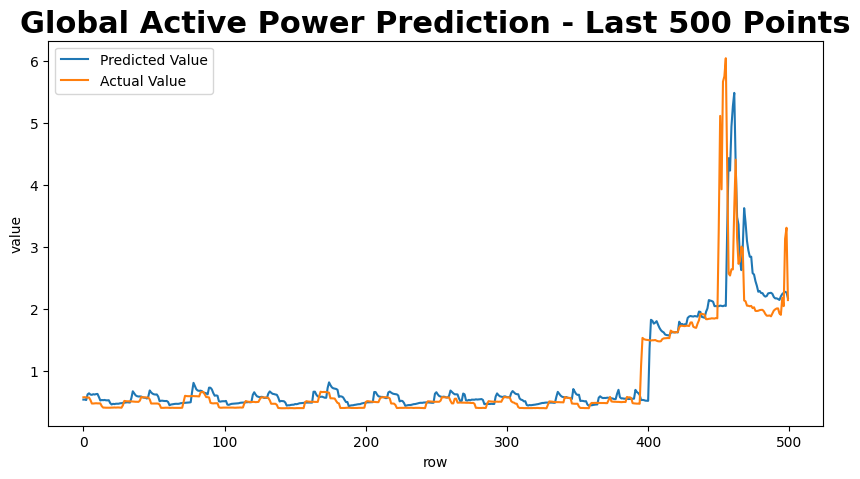

In [130]:
# experimentation model 2 results

val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
for i in range(seq_length, len(val_df) - ph):
    seq = val_df[feat_cols].iloc[i-seq_length:i].values # these are already GAP 
    label = val_df[feat_cols].iloc[i+ph].values[0]

    # save values
    val_arrays.append(seq)
    val_labs.append(label)

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, padding='pre', dtype='float32')
        
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: The model 2 architecutre was modified to increase the number of hidden units and use RMSprop as its optimizer. For this model I think the learning rate was too high since the loss curves are jagged. If I were going to continue to optimize for production I would decrease this learning rate. Then I would aslo increase the number of epoch since it seems like training gets cut short. For the third model architecture I played around with adding a convolutional layer and a pooling layer hoping it would catch onto local paterns and upon look at the model prediction output graph it seems to have done better with the last couple of values (400-500). That is what I was going for so I am happy leaving it there for this assignment but if I were to continue I would lower that learning rate again as well as changing the model sequence length. 

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: The linear regression model from last week performed much better and it was faster to train. In IoT system data may not always be available so choosing a model that requires fewer data points to be effective could be the better strategy if you are looking for a fast MVP. Another thing with the linear regression models is they are computationally lightweight so they can easily be implemented in an IoT system without having to make adjustments to utilize an LSTM that requires more resources. In this specific situation it might be usefule to have a model that we can interprete results from to explain to stakeholders where the LSTMs make it much harder to explain how an input feature influences the prediction. 